In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
import sys
import math
import numpy as np
from math import log, gcd
from random import randint
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import BasicAer, execute
from qiskit.compiler import transpile, assemble
from qiskit.tools.visualization import plot_histogram
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer, IBMQ

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_amod15(qc,qr,cr,a):
    if a == 2:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
    elif a == 7:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 8:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
    elif a == 11: # this is included for completeness
        qc.cswap(qr[4],qr[2],qr[0])
        qc.cswap(qr[4],qr[3],qr[1])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 13:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])

In [3]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_aperiod15(qc,qr,cr,a):
    if a == 11:
        circuit_11period15(qc,qr,cr)
        return
    
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled unitary
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    #   feed forward
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a mod 15
    qc.h(qr[4])
    #   controlled unitary.
    circuit_amod15(qc,qr,cr,a)
    #   feed forward
    qc.u1(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.u1(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

In [4]:
def circuit_11period15(qc,qr,cr):
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    #   feed forward
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply 11 mod 15
    qc.h(qr[4])
    #   controlled unitary.
    qc.cx(qr[4],qr[3])
    qc.cx(qr[4],qr[1])
    #   feed forward
    qc.u1(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.u1(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

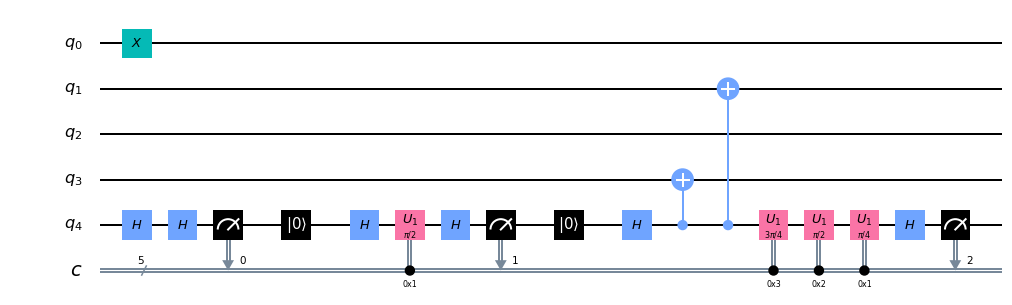

In [5]:
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,11)
shor.draw(output='mpl')

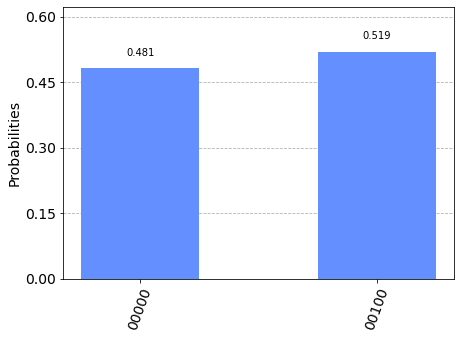

In [6]:
backend = BasicAer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor) 
plot_histogram(sim_data)

In [10]:
def to_binary(N,n_bit):    
    Nbin = np.zeros(n_bit, dtype=bool)
    for i in range(1,n_bit+1):
        bit_state = (N % (2**i) != 0)
        if bit_state:
            N -= 2**(i-1)        
        Nbin[n_bit-i] = bit_state       
    return Nbin

def quantum_period(a,N):    
    n_bit = 5 #number of availables bits in the IBMQ processor
    if N >= 2**n_bit:
        print ("    Error: the number N =", N, "is too big, should be smaller than 2^" + str(n_bit),"=", 2**n_bit)
        print("\n\n")
        sys.exit(0)
    
  #---------------------------------------------------------------------------#
  #------------------------------ Quantum part -------------------------------#
  #---------------------------------------------------------------------------#
    
    print("  Searching the period for N =", N, "and a =", a)
    
    qr = QuantumRegister(n_bit) 
    cr = ClassicalRegister(n_bit)
    qc = QuantumCircuit(qr, cr)
 
    s0 = randint(1, N-1) 
    sbin = to_binary(s0,n_bit)     # Decompose s0 in binary unit for our quantum algorithm
    print("\n      Statrting at \n      s =", s0, "=", sbin)
    
    #initialize the input with s
    for i in range(0,n_bit):
        if sbin[n_bit-i-1]:
            qc.x(qr[i])
            
    s = s0
    r=-1   
    
    # Apply the modular multiplication transformation until we come back to the same initial number s
    while np.logical_or(s != s0, r <= 0):      
        r+=1
        qc.measure(qr, cr) 
        modular_multiplication(qc,qr,cr,a,N)
        results = execute(qc, backend)
        P = results.result().get_counts()
        
        results = [[],[]]
        for k,v in P.items(): #the result should be deterministic but there might be some quantum calculation error so we take the most reccurent output
            results[0].append(k)
            results[1].append(int(v))
        
        index = np.argmax(np.array(results[1]))
        s_str = str(results[0][index])
        
        s = int(s_str, 2)
        print("       ",s_str[::-1])
        
        #sbin = 
  
    print("\n      Found period r =", r)
    return r
       
def modular_multiplication(qc,qr,cr,a,N):
    for i in range(0,3): 
        qc.x(qr[i])
        
    qc.cx(qr[2],qr[1]);
    qc.cx(qr[1],qr[2]);
    qc.cx(qr[2],qr[1]);
    
    qc.cx(qr[1],qr[0]);
    qc.cx(qr[0],qr[1]);
    qc.cx(qr[1],qr[0]);
    
    qc.cx(qr[3],qr[0]);
    qc.cx(qr[0],qr[1]);
    qc.cx(qr[1],qr[0]);
       
if __name__ == '__main__':
    
    a = 11
    N = 15
    r = quantum_period(a,N)

  Searching the period for N = 15 and a = 11

      Statrting at 
      s = 6 = [False False  True  True False]
        01100
        11000
        01000
        10000
        01100

      Found period r = 4


In [11]:
def main():

    print ("\n")
    print ("===========================================")
    print ("             SHOR'S  ALGPRITHM")
    print ("===========================================")
    print ("\n")
    
    #N is the prime factor to be factorized, 
    #    (Currently, the IBMQ processor has 5qbits, 
    #     So the number to be factorized should be less 2^5 = 32)
    
    N = 15
          
    if Check(N):
        p1, p2 = Shor(N)
	
    
def Check(N):

    if N % 2 == 0:
        print ("2 is a trivial factor")
        return False
        
    for k in range(2,int(log(N,2))): #log2(N)
        if pow(N,(1/k)).is_integer():
            print ("N =", pow(N,(1/k)), '^', k)
            return False
    
    return True

def gcd(a, b):   #Compute the GCD with Euclide algorithm
    while b:
        a, b = b, a%b
    return a	
	
	
	
def Shor(N):

    while True:
    
      #1) pick a random number a<N
        #a = randint(1, N-1) 
        a = 11   
    
      #2) check for the GCD(a,N)
        p = gcd(a,N)
        if p != 1:  # We found a nontrivial factor
            p1 = p
            p2 = N/p
            break
        
      #3) Compute the periode r      
        r = quantum_period(a,N)  #Quantum part of the algorithm
        if r % 2 == 0 :
            if a**(r/2) % N != -1:  #If r is a goof period, we found prime factors   
                p1 = gcd(a**(r/2)-1,N)
                p2 = gcd(a**(r/2)+1,N)
                break
                
    print ("\n  N =", int(p1), "*", int(p2))
    return p1, p2
         
if __name__ == '__main__':
    main()



             SHOR'S  ALGPRITHM


  Searching the period for N = 15 and a = 11

      Statrting at 
      s = 13 = [False  True  True False  True]
        10110
        01110
        10010
        00110
        10110

      Found period r = 4

  N = 15 * 1


In [13]:
data = list(sim_data.keys())
for m in data:         
    y = int(m,2)
    f = gcd(2**3,y)
    s = int((2**3)/f)
    f_1 = gcd((a**(s/2))+1,N)
    f_2 = N/f_1
    print("Para x = "+str(y)+": r = "+str(f)+" con n1 = "+str(f_1)+" con n2 = "+str(f_2))

Para x = 0: r = 8 con n1 = 1.7763568394002505e-15 con n2 = 8444249301319680.0
Para x = 4: r = 4 con n1 = 3.0 con n2 = 5.0
